In [20]:
import matplotlib.pyplot as plt

import  seaborn as sns
sns.set_style("darkgrid")

from Utils import *
from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

## get the dataset

In [21]:
(tr_x,tr_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv",unique=True)
results = {}

## Constants

In [22]:
SIZE_RESERVOIR = 300
LAMBDA_REG = 1e-02
MAX_ITER = 1000
PRECISION = 1e-04
LR = 0 # 1/(L+tau) will be chosen 

## fix the resevoir

In [23]:
resevoir = np.random.uniform(-1, 1, (SIZE_RESERVOIR, 10))

In [24]:
H = sigmoid(resevoir@tr_x)

In [25]:
condition_number = np.linalg.cond(H)
print(f"Condition number of H: {condition_number}")

Condition number of H: 5810.338937414097


# OPTIMAL SOLUTION

In [26]:
w_star,_,_,_ = np.linalg.lstsq(H.T, tr_y.T,rcond=-1)
optimal_mse, optimal_residual = mse(w_star.T@H,tr_y), get_residual_y(tr_y,w_star.T@H)
results["optimal"] = (optimal_mse, optimal_residual)

In [27]:
print("Mean square error: ", optimal_mse)
print("Residual: ", optimal_residual)

Mean square error:  1.1220199575197862
Residual:  0.06831949448347181


## Cholesky solution

In [28]:
model = fit_cholesky(tr_x,tr_y, lambda_=LAMBDA_REG, activation="sig", resevoir=resevoir)
mse_cholesky, residual_cholesky = get_results(model,tr_x,tr_y)
results["cholesky"] = (mse_cholesky, residual_cholesky)

In [29]:
print("Mean square error: ", mse_cholesky)
print("Residual: ", residual_cholesky)

Mean square error:  1.15140857394109
Residual:  0.06920844362576994


## Iterative methods

In [30]:
classical_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                        eps=PRECISION, lr=LR, beta=0, resevoir=resevoir, minimum=optimal_mse)
mse_classical_sgd, residual_classical_sgd = get_results(classical_sgd[0],tr_x,tr_y)
results["classical-SGD"] = (mse_classical_sgd, residual_classical_sgd)

In [31]:
momentum_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                       eps=PRECISION, lr=LR, beta=0.5, resevoir=resevoir, minimum=optimal_mse)
mse_momentum_sgd, residual_momentum_sgd = get_results(momentum_sgd[0],tr_x,tr_y)
results["momentum-SGD"] = (mse_momentum_sgd, residual_momentum_sgd)

In [32]:
fista = fit_fista(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                      eps=PRECISION, resevoir=resevoir, minimum=optimal_mse)
mse_fista, residual_fista = get_results(fista[0],tr_x,tr_y)
results["fista"] = (mse_fista, residual_fista)

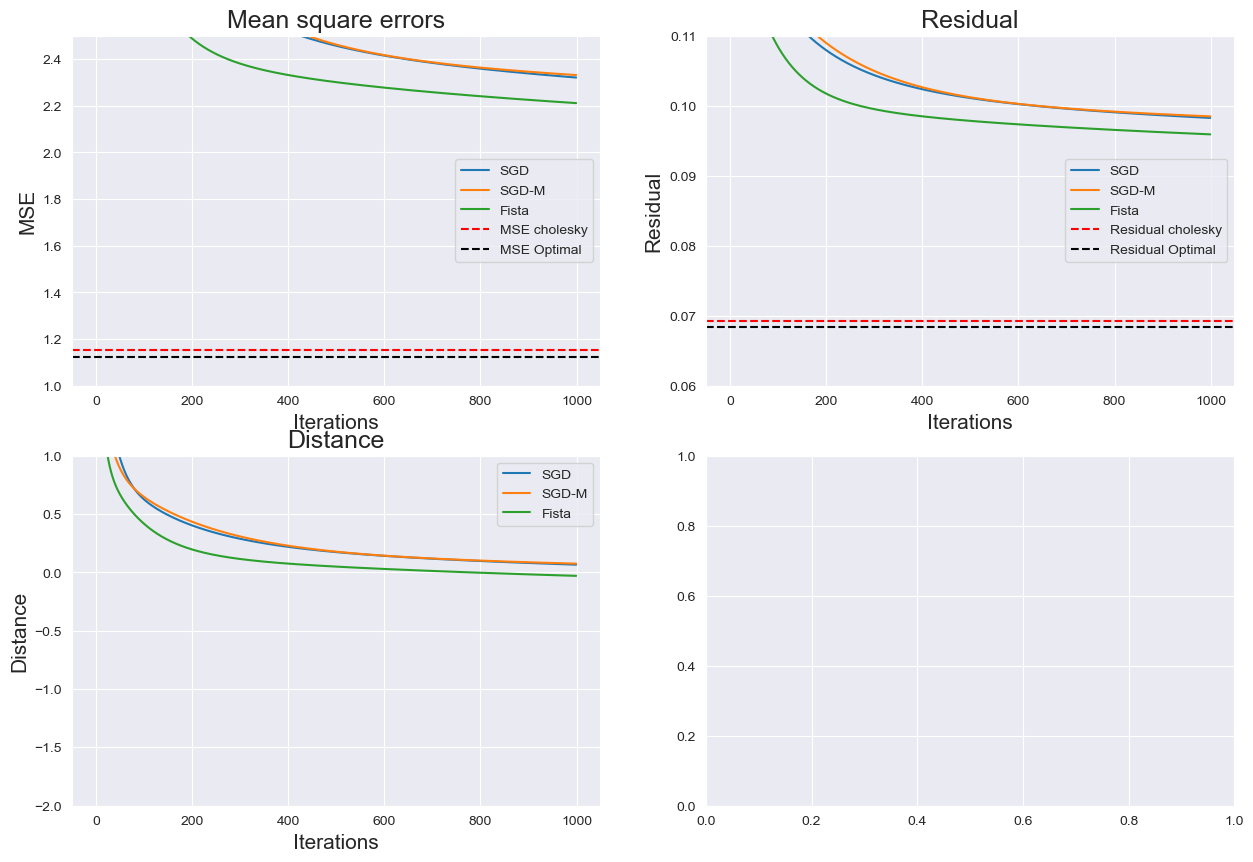

In [33]:
_, axs = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="MSE", ax=axs[0,0], label="SGD")
sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="MSE", ax=axs[0,0], label="SGD-M")
sns.lineplot(data=fista[1], x=fista[1].index, y="MSE", ax=axs[0,0], label="Fista")
axs[0,0].axhline(y=mse_cholesky, label="MSE cholesky", color="red", linestyle="--")
axs[0,0].axhline(y=optimal_mse, label="MSE Optimal", color="black", linestyle="--")
axs[0,0].set_title("Mean square errors",fontsize=18)
axs[0,0].set_ylabel("MSE",fontsize=15)
axs[0,0].set_xlabel("Iterations",fontsize=15)
axs[0,0].set_ylim([1,2.5])
axs[0,0].legend()

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="Residual", ax=axs[0,1], label="SGD")
sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="Residual", ax=axs[0,1], label="SGD-M")
sns.lineplot(data=fista[1], x=fista[1].index, y="Residual", ax=axs[0,1], label="Fista")
axs[0,1].axhline(y=residual_cholesky, label="Residual cholesky", color="red", linestyle="--")
axs[0,1].axhline(y=optimal_residual, label="Residual Optimal", color="black", linestyle="--")
axs[0,1].set_title("Residual",fontsize=18)
axs[0,1].set_ylabel("Residual",fontsize=15)
axs[0,1].set_xlabel("Iterations",fontsize=15)
axs[0,1].set_ylim([0.06,0.11])
axs[0,1].legend()

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="Distance", ax=axs[1,0], label="SGD")
sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="Distance", ax=axs[1,0], label="SGD-M")
sns.lineplot(data=fista[1], x=fista[1].index, y="Distance", ax=axs[1,0], label="Fista")
axs[1,0].set_title("Distance",fontsize=18)
axs[1,0].set_ylabel("Distance",fontsize=15)
axs[1,0].set_xlabel("Iterations",fontsize=15)
axs[1,0].set_ylim([-2,1])
axs[1,0].legend()


plt.show()

In [34]:
print(f"{'Method' : ^20}{'MSE' : ^12}{'Residual' : ^12}")

for k,v in results.items():
    print(f"{k : ^20}{round(v[0],4):^12}{round(v[1],5) : ^12}")

       Method           MSE       Residual  
      optimal          1.122      0.06832   
      cholesky         1.1514     0.06921   
   classical-SGD       2.3208     0.09826   
    momentum-SGD       2.3314     0.09848   
       fista           2.2112     0.09591   
